#Deep Convolutional GAN

##Introducción y arquitectura

La idea general de utilizar modelos generadores es la de poder capturar densidades de probabilidades de muy alta dimensionalidad. Las redes generativas adversarias pueden actuar como funciones que transforman ruido aleatorio, mediante combinaciones y aprendizaje automático, en datos complejos. 

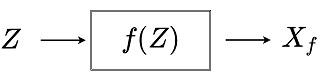

Mediante una técnica adversaria, una red generadora competirá con una red discriminadora en un juego de suma cero. En este juego la red generadora aprenderá a transformar y recrear datos falsos a partir de ruido aleatorio. Por otro lado la red discriminadora aprenderá a diferenciar entre las muestras falsas de las muestras reales.<br>
A medida que el aprendizaje hace mejorar a cada red neuronal, el juego converge a un equilibrio de Nash en el que el discriminador no es capaz de notar la diferencia entre las muestras falsas y las muestras reales. El generador ha ganado el juego, y como resultado ha sido capaz de copiar fehacientemente la distribución de probabilidad de los datos. O eso postula la teoría, por lo menos.

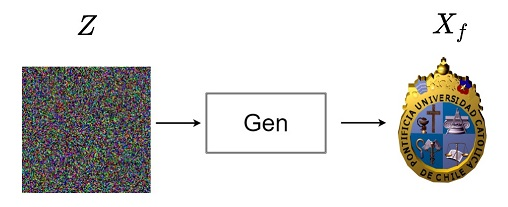

En este práctico veremos una implementación de una de estas técnicas adversarias para entrenar imágenes de MNIST y MNIST-Fashion. Además, veremos cómo, al condicionar una arquitectura a un contexto particular, se pueden manipular las distribuciones de probabilidad aprendidas para que reflejen un diseño intencionado. Por ahora carguemos lo básico.

In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as tfs
import torchvision.datasets as dset
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import time
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using cuda" if torch.cuda.is_available() else "Using cpu" + " as Device")

Quienes hemos trabajado con este tipo de redes sabemos que tienen ciertos desafíos, en especial en su entrenamiento: a veces la convergencia es difícil de obtener. <br>
Un importante avance en este aspecto lo tiene la familia de arquitecturas conocidas como DCGAN. Las siglas provienen de Deep Convolutional Generative Adversarial Nets, y si bien prácticamente todas las GANs que se entrenaban originalmente tienen las características sugeridas en el título, la estabilidad de esta familia les permitió quedarse como la red de facto en su momento.<br> 
En efecto tenemos dos redes neuronales que se entrenan a la par y resuelven un juego competitivo MinMax. Similar a lo visto en la clase teórica el siguiente diagrama especifica los detalles de la arquitectura en particular que utilizaremos en esta ocasión.

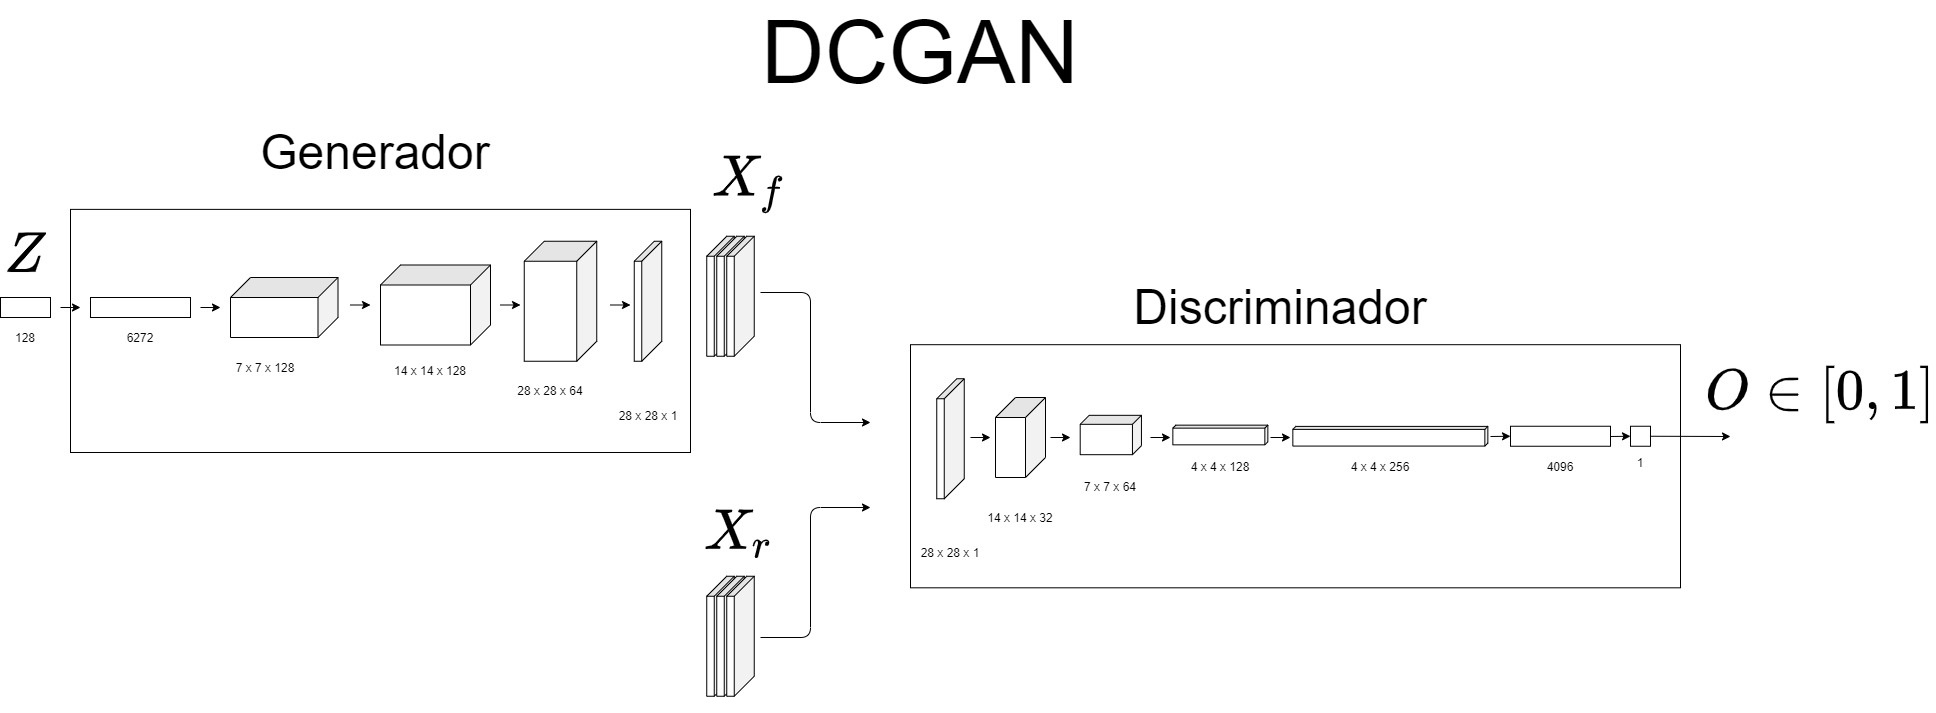

En vez de partir de una imágen de ruido aleatorio, vamos a imaginar que hemos aplastado esa imagen en un latente. Un vector latente, esto es, un vector que proviene de un espacio latente, es un arreglo multidimensional que tiene imformación compactada. En nuestro caso cada dimensión de este vector distribuye normal uniforme. Utilizamos esta distribución pues permite mejor estabilidad en la convergencia.<br>
Para nosotros un vector con ruido tiene máxima entropía, está tan lleno de información que para la mente humana no significa mucho. Necesitamos asociarlo a algo. Para una GAN, partir de un vector así le permitirá explorar un espacio grande de posibilidades, que reducirá según ajuste sus pesos.<br>
En el caso de la figura nuestro latente tiene 128 elementos. Lo pasamos por una capa lineal de 7x7x128 para luego poder transformarlo en un tensor tridimensional. Luego de ello aplicamos sucesivamente capas convolucionales y módulos de Upsampling para darle forma a nuestro mapa de activación. En esta ocasión trabajaremos únicamente con imágenes en blanco y negro por lo que la última capa del generador solo debe tener un filtro.<br>
El discriminador no es diferente de otros clasificadores basados en redes convolucionales. Su única función aparente es la de separar los datos reales de los generados, por lo que solo necesita una única neurona en la última capa. Pero, como veremos más adelante, la propagación del gradiente se hace a través de lo que el discrimandor aprende, por lo que es de mucha importancia.<br>
A este tipo de aprendizase se le denomina semi-supervizado pues, en principio, no necesita etiquetas en el set de datos. Como el discriminador es el único que repite un ezquema parecido al del entrenamiento supervizado las etiquetas virtuales que utilizaremos le asignarán un 1.0 a los datos reales y un 0.0 a los datos generados.

In [ ]:
#@title DCGAN (clases de generador y discriminador)
class Generator_DCGAN(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    #Arquitecture
    #Linear layers
    self.Linear =     nn.Linear(latent_dim, (7 * 7 * latent_dim))
    #Upsampling
    self.UpSample1 =  nn.Upsample(size=14, mode='bilinear')
    self.UpSample2 =  nn.Upsample(size=28, mode='bilinear')
    #Conv layers
    self.Conv2D1 =    nn.ConvTranspose2d(128, 128, 3, padding=1)
    self.Conv2D2 =    nn.ConvTranspose2d(128, 64, 3, padding=1)
    self.Conv2D3 =    nn.ConvTranspose2d(64, 1, 3, padding=1)
    #Barch norms
    self.BatchN2D1 =  nn.BatchNorm2d(128, momentum=0.15)
    self.BatchN2D2 =  nn.BatchNorm2d(64, momentum=0.15)
    #Activation functions
    self.Relu = nn.ReLU()
    self.Tanh = nn.Tanh()

  def forward(self, z):
    batch_size = z.shape[0]
    x = self.Linear(z)
#    x = x.clone() #reinitiliaze gradient
    x = self.Relu(x)
    x = x.view(batch_size, -1, 7, 7)
    x = self.UpSample1(x)
    x = self.Conv2D1(x)
    x = self.BatchN2D1(x)
    x = self.Relu(x)
    x = self.UpSample2(x)
    x = self.Conv2D2(x)
    x = self.BatchN2D2(x)
    x = self.Relu(x)
    x = self.Conv2D3(x)
    x = self.Tanh(x)
    return x

class Discriminator_DCGAN(nn.Module):
  def __init__(self, img_shape):
    super().__init__()
    #Arquitecture
    #Conv layers
    self.Conv2D1 =   nn.Conv2d(1, 32, 3, stride=2, padding=1)
    self.Conv2D2 =   nn.Conv2d(32, 64, 3, stride=2, padding=1)
    self.Conv2D3 =   nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.Conv2D4 =   nn.Conv2d(128, 256, 3, padding=1)
    #Barch norms
    self.BatchN2D1 = nn.BatchNorm2d(64, momentum=0.15)
    self.BatchN2D2 = nn.BatchNorm2d(128, momentum=0.15)
    self.BatchN2D3 = nn.BatchNorm2d(256, momentum=0.15)
    #Linear layers
    self.Linear  =   nn.Linear(4096, 1)
    #Activation functions
    self.LRelu = nn.LeakyReLU(negative_slope=0.2)
    self.Drop = nn.Dropout2d(p=0.25)
    self.Sigm = nn.Sigmoid()

  def forward(self, img):
    batch_size = list(img.shape)[0]
 #   x = self.initialize_hidden(batch_size)
    x = self.Conv2D1(img)
 #   x = x.clone() #reinitiliaze gradient
    x = self.LRelu(x)
    x = self.Drop(x)
    x = self.Conv2D2(x)
    x = self.BatchN2D1(x)
    x = self.LRelu(x)
    x = self.Drop(x)
    x = self.Conv2D3(x)
    x = self.BatchN2D2(x)
    x = self.LRelu(x)
    x = self.Drop(x)
    x = self.Conv2D4(x)
    x = self.BatchN2D3(x)
    x = self.LRelu(x)
    x = self.Drop(x)
    x = x.view(batch_size,-1)
    x = self.Linear(x)
    x = self.Sigm(x)
    return x.view(batch_size)

class GAN(nn.Module):
  def __init__(self, gen, dis):
    super().__init__()
    self.gen = gen
    self.dis = dis

  def forward(self, noise, img_batch=None, train=False):
    return noise

Para quienes investiguen con más profundidad las clases verán unas cuantas particularidades. Primero, casi todas las capas, tanto en el generador como en el discriminador utilizan normalización del batch. Se hace esto para que las redes puedan trabajar con una distribución predecible de datos, y no tengan que ajustar estas variables directamente de los pesos. Esto aporta estabilidad. Nunca se utiliza normalización en la entrada del discriminador o a la salida del generador. Solo en esos casos se deja a los pesos propios de los filtros acomodarse a las distribuciones de los datos.<br>
Además, para controlar los tamaños de los mapas de activación se manipulan los pasos (strides) de los filtros convolucionales, tanto para el generador como para el discriminador. El generador utiliza deconvoluciones y, en contadas ocasiones upsampling. El discriminador nunca utiliza heurísticas como maxpooling pues afectan negativamente la convergencia.<br>
Finalmente, las funciones de activación se toman con mucho cuidado. Se utiliza Relu o LeakyRelu en el generador para todas las capas intermedias, en el discriminador se utiliza exclusivamente LeakyRelu. Esto permite mantener una relación de invertibilidad de los datos (aunque no se inviertan). Así se puede mantener una correspondencia 1 a 1 entre un vector de ruido con uno de datos. Las funciones de activación de las capas finales son Tanh para el generador y Sigmoide para el discriminador.

## Funciones de pérdida y propagación de gradiente

Originalmente la función de pérdida del sistema completo tiene la siguiente forma: 
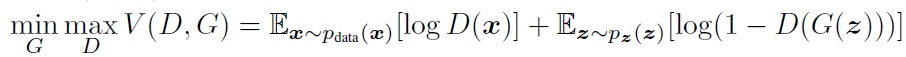

Sin embargo, este sistema es muy inestable y se separa el problema asignando una pérdida para el generador:
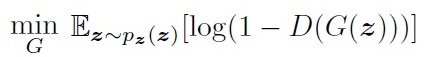
<br>



 y otra para el discriminador:<br>
 
 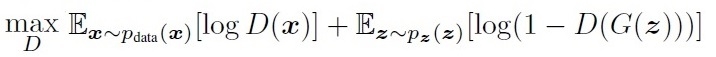

Se hace este truco para evitar que el gradiente del discriminador se sature hacia el generador. Aquí el generador directamente maximiza la probabilidad de error del discriminador, pero el equilibrio ya no se puede describir con una única función de pérdida. Como resultado el generador todavía puede aprender incluso cuando el discriminador rechaza de manera exitosa todas las muestras.<br>
Como ahora disponemos de dos pérdidas debemos propagar el gradiente en etapas. Ayuda a estos fines el tener tanto el generador como el discriminador separados como dos redes independientes.

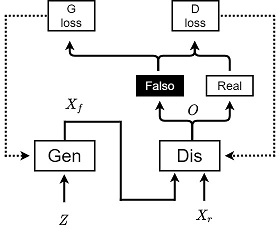

Un truco similar se hace al mover los límites de las etiquetas: esto se denomina etiquetado suave en un lado. Se realiza cambiando el valor de las etiquetas de los datos reales de 1.0 a 0.9. Lo que hace esto último es introducir una probabilidad de fuga en la que podemos considerar que hemos dado datos erróneos como entregar una imagen falsa que en realidad es real. Esto ayuda un poco al discriminador. En este ejemplo se realiza, tanto en la pérdida del generador como del discriminador, las etiquetas falsas pasan a ser de 0.3, y las verdaderas de 0.7. Esto permite sobreevaluar los valores, aunque hace que las categorías estén más cercanas y difíciles para el discriminador. En el caso de MNIST no resulta en un problema e incluso ayuda en la convergencia. 

In [ ]:
#@title GAN: loss and train loop

def discriminator_loss(real_output, fake_output):
  real_loss = F.binary_cross_entropy(real_output, 0.7*torch.ones_like(real_output))
  fake_loss = F.binary_cross_entropy(fake_output, 0.3*torch.zeros_like(fake_output))  
  return real_loss + fake_loss

def generator_loss(fake_output):
  return F.binary_cross_entropy(fake_output, 0.7*torch.ones_like(fake_output))

def gan_epoch(gen, dis, loader, gen_opti, dis_opti, train_model=True):

    if (train_model):
      gen.train()
      dis.train()
    else:
      gen.eval()
      dis.eval()
      torch.no_grad()
        
    gen_mean_loss = 0
    dis_mean_loss = 0

    for (batch, labels, noise) in loader:
        real_imgs = batch.to(DEVICE)
        z = noise.to(DEVICE)
        #z = torch.randn((batch_size, latent_dim)).to(DEVICE)
        gen.zero_grad()
        dis.zero_grad()
        fake_imgs   = gen(z)
        real_output = dis(real_imgs)
        fake_output = dis(fake_imgs)

        dis_loss = discriminator_loss(real_output, fake_output)
        dis_opti.zero_grad()
        dis_loss.backward(retain_graph=True)
        dis_opti.step()
        dis_mean_loss += dis_loss.item()

        fake_output = dis(fake_imgs)
        gen_loss = generator_loss(fake_output)
        gen_opti.zero_grad()
        gen_loss.backward(retain_graph=True)
        gen_opti.step()
        gen_mean_loss += gen_loss.item()

    gen_mean_loss /= len(loader.dataset)
    dis_mean_loss /= len(loader.dataset)

    return gen_mean_loss, dis_mean_loss

def train_gan(nepochs, gen, dis, train_loader, valid_loader, gen_opti, dis_opti, name='mnist'):

    static_vectors = torch.randn((8, latent_dim)).to(DEVICE)
    accum_gen_t_loss = []
    accum_dis_t_loss = []
    accum_gen_v_loss = []
    accum_dis_v_loss = []

    for epoch in range(nepochs):
    
        start = time.time()

        gen_t_loss, dis_t_loss = gan_epoch(gen, dis, train_loader, gen_opti, dis_opti, train_model=True)
        gen_v_loss, dis_v_loss = gan_epoch(gen, dis, valid_loader, gen_opti, dis_opti, train_model=False)
        accum_gen_t_loss.append(gen_t_loss)
        accum_dis_t_loss.append(dis_t_loss)
        accum_gen_v_loss.append(gen_v_loss)
        accum_dis_v_loss.append(dis_v_loss)

        msj = 'Epoch {:03d}: time {:.3f} sec, gen_t_loss {:.3f}, dis_t_loss {:.3f}, gen_v_loss {:.3f}, dis_v_loss {:.3f}'
        print(msj.format(epoch+1, time.time()-start, gen_t_loss, dis_t_loss, gen_v_loss, dis_v_loss))

        generated = gen(static_vectors)
        discriminated = dis(generated).cpu().detach().numpy()
        fig = plt.figure(figsize=(16,2))

        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(generated[i, 0, :, :].cpu().detach().numpy(), cmap='gray_r')
            msj = 'Real {:.3f}' if discriminated[i] >= 0.5 else 'Fake {:.3f}'
            # plt.xlabel(msj + output_label(predictions[i]))
            plt.xlabel(msj.format(discriminated[i]))
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

        plt.show()

        torch.save(gen.state_dict(), './gen_' + name + '.pth')
        torch.save(dis.state_dict(), './dis_' + name + '.pth')

    fig = plt.figure(figsize=(12.8,9.6))
    plt.subplot(2, 3, 1)
    plt.plot(list(range(nepochs)), accum_gen_t_loss)
    plt.title('Generator training loss')
    plt.subplot(2, 3, 2)
    plt.plot(list(range(nepochs)), accum_dis_t_loss)
    plt.title('Discriminator training loss')
    plt.subplot(2, 3, 3)
    plt.plot(list(range(nepochs)), accum_gen_t_loss, list(range(nepochs)), accum_dis_t_loss)
    plt.title('Generator and discriminator training loss')
    plt.subplot(2, 3, 4)
    plt.plot(list(range(nepochs)), accum_gen_v_loss)
    plt.title('Generator validation loss')
    plt.subplot(2, 3, 5)
    plt.plot(list(range(nepochs)), accum_dis_v_loss)
    plt.title('Discriminator validation loss')
    plt.subplot(2, 3, 6)
    plt.plot(list(range(nepochs)), accum_gen_v_loss, list(range(nepochs)), accum_dis_v_loss)
    plt.title('Generator and discriminator validation loss')
    plt.show()

#Pytorch MNIST DCGAN

Construimos una clase dataset para MNIST. Utilizamos las transformaciones típicas para el problema, y las dimensiones adecuadas a la arquitectura y tamaño de imágenes.

In [ ]:
import tensorflow as tf
batch_size = 64
img_shape = (1, 28, 28)
latent_dim = 128
data_transforms = tfs.Compose([tfs.ToTensor(), tfs.Normalize([0.5], [0.5])])
pytorch_mnist = False

class DigitDataset(torch.utils.data.Dataset):
        
    def __init__(self, transforms, latent_dim, train=True, pytorch=True):
        if pytorch:
            self.mnist = torchvision.datasets.MNIST('.', download=True, transform=transforms, train=train)
            self.z = torch.randn((len(self.mnist), latent_dim))
        else:
            (self.x_train, self.y_train), (self.x_test, self.y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
            if train:
                self.z = torch.randn((len(self.x_train), latent_dim))
            else:
                self.z = torch.randn((len(self.x_test), latent_dim))

        self.pytorch = pytorch
        self.train = train
        self.transforms = transforms

    def __getitem__(self, idx):
        if self.pytorch:
            (images, labels) = self.mnist[idx]
        else:
            if self.train:
                images = self.transforms(self.x_train[idx])
                labels = self.y_train[idx]
            else: 
                images = self.transforms(self.x_test[idx])
                labels = self.y_test[idx]
        return images, labels, self.z[idx]

    def __len__(self):
        if self.pytorch:
            size = len(self.mnist)
        else:
            if self.train:
                size = len(self.x_train)
            else:
                size = len(self.x_test)
        return size

train_set = DigitDataset(data_transforms, latent_dim, train=True, pytorch=pytorch_mnist)
valid_set = DigitDataset(data_transforms, latent_dim, train=False, pytorch=pytorch_mnist)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

def output_label(label):
    return '{}'.format(label)

Tomando una muestra aleatoria del set de datos.

In [ ]:
for (batch, label, noise) in train_loader:
  break
print(batch.shape)
print(label[:16].view(4,4))

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(batch[i].view(28,28), cmap="gray_r")
    plt.xlabel('{}'.format(label[i]))


Al iniciar las redes y generar ruido obtenemos una salida sin una forma específica. Pese a ser ruido no vemos la típica pantalla con hormigas luego de pasar este ruido por el generador, ¿por qué?

In [ ]:
gen = Generator_DCGAN(latent_dim)
dis = Discriminator_DCGAN(img_shape)
noise = torch.randn((1, latent_dim))
img = gen(noise)
plt.imshow(img[0, 0, :, :].detach().numpy(), cmap='gray_r')
plt.axis('off')
plt.show()
decision = dis(img)
print(decision)

In [ ]:
#Entrenamiento completo (NO EJECUTAR NI BORRAR)
gen = Generator_DCGAN(latent_dim).to(DEVICE)
dis = Discriminator_DCGAN(img_shape).to(DEVICE)
gen_opti = torch.optim.Adam(gen.parameters(), lr=0.0001)
dis_opti = torch.optim.Adam(dis.parameters(), lr=0.0001)
train_gan(100, gen, dis, train_loader, valid_loader, gen_opti, dis_opti)

En el entrenamiento tanto generador como discriminador compiten por aumentar la pérdida de la otra red. Teóricamente un sistema GAN bien entrenado llegará a un equilibrio de Nash tal que el discriminador no puede diferenciar entre distribución de las muestras de las de los datos generados. Sin embargo, mucho antes que eso ocurra el sistema puede mostrar ejemplos decentes de generación que mejoran en cada época.

#Pytorch FashionMNIST DCGAN

Esta sección cumple la misma función que la anterior. Lo interesante es que al cambiar el set de datos a uno más complejo la arquitectura siguie realizando un buen trabajo. 

In [ ]:
batch_size = 64
img_shape = (1, 28, 28)
latent_dim = 128
data_transforms = tfs.Compose([tfs.ToTensor(), tfs.Normalize([0.5], [0.5])])

class ClothesDataset(torch.utils.data.Dataset):
        
    def __init__(self, transforms, latent_dim, train=True):
        self.mnist = torchvision.datasets.FashionMNIST('.', download=True, transform=transforms, train=train)
        self.z = torch.randn((len(self.mnist), latent_dim))

    def __getitem__(self, idx):
        (images, labels) = self.mnist[idx]
        return images, labels, self.z[idx]

    def __len__(self):
        return len(self.mnist)

train_set = ClothesDataset(data_transforms, latent_dim, train=True)
valid_set = ClothesDataset(data_transforms, latent_dim, train=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

def output_label(label):

    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
for (batch, label, noise) in train_loader:
  break
print(batch.shape)
print(label[:16].view(4,4))

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(batch[i].view(28,28), cmap="gray_r")
    plt.xlabel('{}'.format(output_label(label[i])))

In [ ]:
gen = Generator_DCGAN(latent_dim)
dis = Discriminator_DCGAN(img_shape)
noise = torch.randn((1, latent_dim))
img = gen(noise)
plt.imshow(img[0, 0, :, :].detach().numpy(), cmap='gray_r')
plt.axis('off')
plt.show()
decision = dis(img)
print(decision)

In [ ]:
gen = Generator_DCGAN(latent_dim).to(DEVICE)
dis = Discriminator_DCGAN(img_shape).to(DEVICE)
gen_opti = torch.optim.Adam(gen.parameters(), lr=0.0001)
dis_opti = torch.optim.Adam(dis.parameters(), lr=0.0001)
train_gan(100, gen, dis, train_loader, valid_loader, gen_opti, dis_opti, name='fashion')

In [ ]:
from google.colab import files
files.download('dis_mnist.pth')
files.download('gen_mnist.pth')
files.download('dis_fashion.pth')
files.download('gen_fashion.pth')

# CycleGan y Pix2Pix

Finalmente veremos una aplicación interesante: transferencia de estilo. Para ello vamos a utilizar CycleGan (y su homólogo Pix2Pix). El artículo original lo pueden revisar [aquí](https://arxiv.org/pdf/1611.07004.pdf).<br>
Las GANs han sido altamente valoradas debido tanto a sus capacidades de aprender complejas densidades de probabilidades de datos, como a la característica que les permite ser entrenadas sin la necesidad de una etiqueta. La gran mayoría de los algoritmos exitosos de aprendizaje profundo actuales utilizan grandes y costosos sets de datos para su entrenamiento. El poder reducir la dependencia de las etiquetas ayuda a reducir los costos de estos sets de datos.<br>
Además de estas razones de peso las GANs han ganado mucha popularidad debido a sus impresionantes efectos visuales. El siguiente trabajo nos muestra lo que sucede cuando se puede condicionar una GAN a una densidad de probabilidades "de diseño". El condicionamiento se obtiene cuando al sistema se le entrega información perceptual diferente del vector de ruido $z$. Así, la GAN recibe un valor de probabilidad a priori que depende de esta nueva información. Para que funcione correctamente tanto el generador como el discriminador deben tener accesible dicha información.



Como siempre, comenzamos descargando los códigos originales del repositorio y los respectivos pesos de los modelos preentrenados.

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -qr requirements.txt

In [ ]:
!bash ./scripts/download_cyclegan_model.sh summer2winter_yosemite 
!bash ./scripts/download_cyclegan_model.sh winter2summer_yosemite 
!bash ./scripts/download_cyclegan_model.sh monet2photo 
!bash ./scripts/download_cyclegan_model.sh style_monet 
!bash ./scripts/download_cyclegan_model.sh style_cezanne 
!bash ./scripts/download_cyclegan_model.sh style_ukiyoe 
!bash ./scripts/download_cyclegan_model.sh style_vangogh
!bash ./scripts/download_cyclegan_model.sh facades_photo2label
!bash ./scripts/download_cyclegan_model.sh facades_label2photo
# !bash ./scripts/download_pix2pix_model.sh facades_label2photo 
!bash ./scripts/download_pix2pix_model.sh day2night 
!bash ./scripts/download_pix2pix_model.sh edges2shoes 
from google.colab import output
output.clear()

Los autores han presentado un proyecto con códigos debidamente identados y autocontenidos. Para utilizarlos se debe disponer de una carpeta con las imágenes objetivo.

In [ ]:
!mkdir imgs/toGAN

Originalmente los códigos corren directamente desde el archivo test.py. Una forma de correrlos es esribir una función que simula recibir los argumentos desde la consola.<br>

In [ ]:
import sys
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.util import tensor2im

def initmodels():
    weights = {
        'day2night': 'day2night_pretrained',
        'monet2photo' : 'monet2photo_pretrained',
        'monet' : 'style_monet_pretrained',
        'ukiyoe' : 'style_ukiyoe_pretrained', 
        'cezanne' : 'style_cezanne_pretrained',
        'vangogh' : 'style_vangogh_pretrained',
        'label2photo' : 'facades_label2photo_pretrained',
        'photo2label' : 'facades_photo2label_pretrained',
        'summer2winter' : 'summer2winter_yosemite_pretrained',
        'winter2summer' : 'winter2summer_yosemite_pretrained',
        'edges2shoes' : 'edges2shoes_pretrained'
    }

    models = {}

    for key in list(weights.keys()):
        opts = ['--dataroot', 'imgs', '--name', weights[key]]
        if key == 'day2night':
            opts += '--direction AtoB --model pix2pix'.split()
        elif key == 'edges2shoes':
            opts += '--direction BtoA --model pix2pix'.split()
        else:
            opts += '--model test --no_dropout'.split()
        # sys.argv[1:] = ['--dataroot', 'imgs', '--name', weights[key]] + '--model test --no_dropout'.split()
        print(opts)
        sys.argv[1:] = opts
        opt = TestOptions().parse()  # get test options
        # hard-code some parameters for test
        opt.num_threads = 0   # test code only supports num_threads = 0
        opt.batch_size = 1    # test code only supports batch_size = 1
        opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
        opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
        opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
        model = create_model(opt)      # create a model given opt.model and other options
        model.setup(opt)               # regular setup: load and print networks; create schedulers
        model.eval()
        models[key] = model

    return models

models = initmodels()
output.clear()

def transform_to(path, styles):  

    sys.argv[1:] = ['--dataroot', path]
    opt = TestOptions().parse()  # get test options
    # hard-code some parameters for test
    opt.num_threads = 0   # test code only supports num_threads = 0
    opt.batch_size = 1    # test code only supports batch_size = 1
    opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
    opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
    opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
    dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options

    imgs = []
    reals = []
    fakes = []

    for i, data in enumerate(dataset):
        if i >= opt.num_test:
            break
        sample = {}
        for j, style in enumerate(styles):
            net = models[style]
            net.set_input(data)
            net.test()
            visuals = net.get_current_visuals()
            for label, im_data in visuals.items():
                im = tensor2im(im_data) #returns numpy arrays with the corresponging image
                if label == 'real' and j == 0:
                    sample['real'] = im
                else:
                    sample[style] = im
        imgs.append(sample)

    return imgs

Con estas modificaciones podemos probar, no solo varias imágenes a la vez, sino también varios estilos al mismo tiempo. Para ello le indicamos al algoritmo la carpeta con las imágenes, y en una lista los estilos que queremos que aplique. El resultado es una lista de diccionarios, con la imagen real y todas las transformadas.<br>
Cargue las imágenes *Navigation-Lake-Patagonia-Pehoe.jpg* y *Polo.jpeg* en una misma carpeta *imgs/toGAN* y aplique los estilos *winter2summer* y *vangogh* al mismo tiempo a la carpeta.


In [ ]:
imgs = transform_to('imgs/toGAN', ['winter2summer', 'vangogh'])

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

for img in imgs:
    for i, key in enumerate(list(img.keys())):
        if i == 0:
            collage = img[key]
        else:
            collage = np.concatenate((collage, img[key]), axis=1)

    plt.figure(figsize=(18, 6*(i+1)))
    plt.imshow(collage)
    plt.axis('off')
    plt.show()

En este caso tratamos de transformar desde invierno a verano con ambas imágenes, cosa que no es adecuada para el perro. Por otro lado la transformación de estilo a un cuadro de Vangogh se ve bien en ambos casos. <br>
Utilicemos solamente al perro, pero con todos los estilos de pintores disponibles.

In [ ]:
keys = ['monet', 'ukiyoe', 'cezanne', 'vangogh']
imgs = transform_to('imgs/toGAN', keys)
output.clear()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

img = imgs[1] #escogemos únicamente al perro
r = 0
for i, key in enumerate(keys): #Iterando así ignoramos img['real'] que ya conocemos
    if i%2 == 0:
        row = img[key]
    else:
        row = np.concatenate((row, img[key]), axis=1)
        if r == 0:
            collage = row
            r += 1
        else:
            collage = np.concatenate((collage, row), axis=0)

plt.figure(figsize=(12, 12))
plt.imshow(collage)
plt.axis('off')
plt.show()

Hasta ahora hemos utilizado la arquitectura CycleGAN. También tenemos disponible Pix2Pix, pero éste es un poco más exigente con la estructura de las imágenes. Primero necesitamos específicamente una carpeta "test" dentro de nuestra ruta. <br> Dejaremos una carpeta únicamente para el trabajo de esta nueva imagen. Cargue la imagen *adidas.jpg*.

In [ ]:
!mkdir imgs/toPix2Pix imgs/toPix2Pix/test

En este caso vamos a transformar los bordes de una zapatilla en una lo más parecido a una real.

In [ ]:
import cv2
from PIL import Image

img = cv2.imread('adidas.jpg')
display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

Utilizamos el detector de bordes ```cv2.canny()``` para sacar los bordes requeridos. Los cógidos automáticamente van a cortar la imagen pues supone un modelo del tipo A|B donde la transformación se puede realizar de A a B o al revés.<br>
Por simplicidad clonamos y concatenamos la imagen para engañar a los códigos.

In [ ]:
def edge_detector(image, sigma=0.33):
    median = np.median(image)
    lower = int(max(0, (1.0 - sigma) * median))
    upper = int(min(255, (1.0 + sigma) * median))
    return cv2.Canny(image, lower, upper)

img = edge_detector(img, sigma=0.33)
img = np.concatenate((img, img), axis=1)
cv2.imwrite('imgs/toPix2Pix/test/zapatilla.jpg', 255 - img)
display(Image.fromarray(cv2.cvtColor(255 - img, cv2.COLOR_BGR2RGB)))

Esta arquitectura funciona bien desde sus códigos originales, por lo que respetaremos toda su estructura original.

In [ ]:
!python test.py --dataroot imgs/toPix2Pix --direction AtoB --model pix2pix --name edges2shoes_pretrained

Estos códigos crean una carpeta de resultados donde guardan las imágenes generadas y unas copias de las originales.

In [ ]:
img = cv2.imread('imgs/adidas.jpg')
im1 = cv2.imread('results/edges2shoes_pretrained/test_latest/images/zapatilla_fake_B.png')
im2 = cv2.imread('results/edges2shoes_pretrained/test_latest/images/zapatilla_real_A.png')

width, height, _ = img.shape
im1 = cv2.resize(im1, (height, width))
im2 = cv2.resize(im2, (height, width))

concat = np.concatenate([img, im2, im1], axis=1)

display(Image.fromarray(cv2.cvtColor(concat, cv2.COLOR_BGR2RGB)))

# Actividades

Las siguientes actividades pueden resolverse en parejas. Tenga en cuenta que esto es una excepción al funcionamiento normal del diplomado. El hecho de que este laboratorio esté autorizado a ser resuelto en parejas no establece precedente para otras actividades. Salvo que cada profesor lo autorice de manera explícita, los laboratorios deben entregarse de manera individual.

## Problema 1 - 3 puntos
 

Entrene la GAN casera para generar dígitos del set de datos MNist. Programe y entrene un clasificador para este mismo set de datos. Genere una suficiente cantidad de números y clasifique su generación. Seleccione un elemento de cada clase, y concaténelos utilizando la función ```np.concatenate()``` para desarrollar un pad numérico visual de 3x3 dígitos.

###Solución

## Problema 2 - 1 punto

Vamos a trabajar con fachadas de edificios en dos formas. Las redes CycleGan y Pix2Pix se han entrenado como un modelo que transforma un mapa de un espacio a otro, por ejemplo A|B de A a B, pero dicha transformación en algunos dominios puede invertirse (de B a A). <br>
Un ejemplo clásico sería el entrenar las redes con imágenes claras y otras difuminadas mediante filtros clásicos de difuminación. La idea de hacer esto no es tener una red que aprenda a difuminar fotografías, pues esto es fácil (por ejemplo con una máscara que promedie su vecindad). Lo realmente interesante se encuentra en la operación inversa, que en este caso sería denominada superresolución: una red que aprende a quitar el difuminado.<br>
En este problema vamos a trabajar con un caso con más información semántica. Vamos a convertir las fotos de un edificio en su versión de segmentación semántica (similar al uso de Mask-RCNN) y vamos a recuperar esa información con la transformación inversa. De manera similar al ejemplo de la zapatila.<br>
Primero, cargue la imagen bulding front en una carpeta de su elección. Utilice la opción *photo2label* para obtener una representación semántica de la fachada. Guarde su imagen en otra carpeta y procese esta nueva imagen con la opción *label2photo* para crear una fachada falsa. Concatene las tres imágenes, la original, la representación semántica y la fachada falsa para desplegarlas juntar. Utilice ```np.concatenate()```.  <br>
Segundo, cargue una imagen manualmente preparada. Puede utilizar editores de imágenes como *paint* o hace uso de OpenCv para generar de manera procedural la imagen mediante ```cv2.rectangle()```. Transforme esta imagen a utilizando la opción *label2photo* para obtener una fachada "realista". Comente sobre los errores de generación, y la calidad de la imagen obtenida.



### Solución

In [ ]:
#Colors for facade
background = (5, 5  , 220)
facade = (5, 50, 250)
up = (250, 80, 5)
overwindow = (40, 230, 210)
window = (5, 128, 250)
downwindow = (250, 160, 5)
door = (160, 5, 15)